# Generate Data and Make Plots for the Paper

This notebook will generate all of the data and plots used in the paper. Please refer to **Evaluating Black Hole Detectability with LISA** (arXiv:1807.02511). The tool used to perform this analysis is BOWIE, Binary Observability With Illustrative Exploration. See ``BOWIE_basic_examples.ipynb`` for information on building data sets and basic plots with BOWIE. All of these data will be produced in parallel with the multiprocessing module in python. The noise curves shown can be found in the form of an amplitude spectral density (ASD) in the "noise_curves" folder in the github. 

Please refer to and cite (arXiv:1807.02511) for usage of this tool and an example of its application. The codes here are shared under the GNU license. 

### Note: This is an updated version of BOWIE. Therefore, the plot aesthetics will look slightly different than the paper, but the plot information is the same.

In [2]:
import os
import copy
#os.chdir('/Users/michaelkatz/Documents/Research/PythonCodes/BOWIE_analysis/snr_calculator_folder/')
from gwsnrcalc.generate_contour_data import generate_contour_data
from gwsnrcalc.genconutils.forminput import MainContainer as GenInput
#os.chdir('/Users/michaelkatz/Documents/Research/PythonCodes/BOWIE_analysis/')
from bowie_makeplot.make_plot import plot_main
from bowie_makeplot.plotutils.forminput import MainContainer as PlotInput
from gwsnrcalc.utils.waveforms import PhenomDWaveforms
from gwsnrcalc.utils.readnoisecurves import read_noise_curve
from gwsnrcalc.gw_snr_calculator import snr
import scipy.constants as ct
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Msun = 1.989e30
os.chdir('/Users/michaelkatz/Documents/Research/PythonCodes/BOWIE_analysis/notebooks/')

## Figure 1: Sensitivity Curves

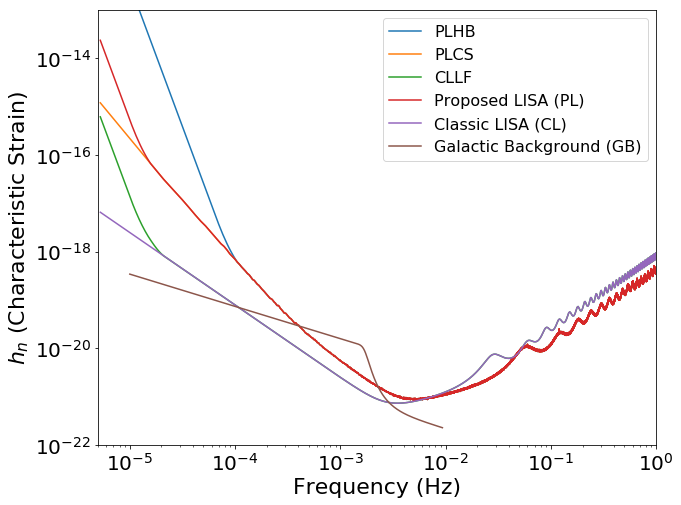

In [4]:
fig = plt.figure()
fig.set_size_inches(10,8)
for name in ['PLHB', 'PLCS', 'CLLF', 'PL', 'CL', 'HB_wd_noise']:
    f, hn = read_noise_curve(name, noise_type_in='ASD', noise_type_out='char_strain')
    if name == 'PL':
        name = 'Proposed LISA (PL)'
    if name == 'CL':
        name = 'Classic LISA (CL)'
    if name == 'HB_wd_noise':
        name = 'Galactic Background (GB)'
    plt.loglog(f, hn, label = name)

plt.xlim(5e-6,1e0)
plt.ylim(1e-22, 1e-13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$h_n$ (Characteristic Strain)', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=22)
plt.legend(loc='upper right', prop={'size':16})
#fig.savefig('Sensitivity_curves.png', dpi=250)

## Figure 2: Waveform Example

Text(0.5,0.05,'Frequency (Hz)')

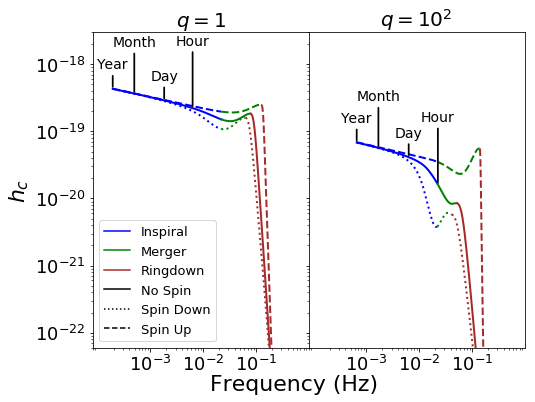

In [2]:
# initialize the waveform generator
phenomdwave = PhenomDWaveforms(dist_type='redshift', num_points=4096)

fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig1.set_size_inches(8,6)
plt.subplots_adjust(wspace=0.0, left=0.15, bottom=0.15)

M = 1e5
z = 1.0
start_time = 1.0
end_time = 0.0
ax1.set_title(r'$q=1$', fontsize=20)
ax2.set_title(r'$q=10^{2}$', fontsize=20)
for q, ax in [[1, ax1], [1/100,ax2]]:
    ax.set_ylim(6e-23, 3e-18)
    ax.set_xlim(8e-5, 1e0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    for s, ls in [[-1.0, 'dotted'], [0.0, 'solid'], [1.0,'dashed']]:
        m1 = M/(1+q)
        m2 = M*q/(1+q)
        wave = phenomdwave(m1, m2, s, s, z, start_time, end_time)
        
        f = wave.freqs
        hc = wave.hc*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018
        
        ins = np.where(f<wave.fmrg)[0]
        mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
        rd = np.where(f>wave.fpeak)[0]
        
        ax.loglog(f[ins], hc[ins], color='blue', ls = ls, lw = 2)
        ax.loglog(f[mrg], hc[mrg], color='green', ls = ls, lw = 2)
        ax.loglog(f[rd], hc[rd], color='brown', ls = ls, lw = 2)
        if s == 0.0:
            N = m1*m2/(m1+m2)**2.
            start_times = np.array([1.0,1.0/12.0, 1.0/365.25,1.0/(365.25*24.0)])*ct.Julian_year/(1+z)

            tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
            flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

            f_1y_ind = np.where(f >= flow[0])[0][0]
            f_1m_ind = np.where(f >= flow[1])[0][0]
            f_1d_ind = np.where(f >= flow[2])[0][0]
            f_1h_ind = np.where(f >= flow[3])[0][0]

            ax.annotate("Year",xy=(f[f_1y_ind], hc[f_1y_ind]), xycoords='data',xytext=(0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            ax.annotate("Month",xy=(f[f_1m_ind], hc[f_1m_ind]), xycoords='data',xytext=(0.0, 47), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            ax.annotate("Day",xy=(f[f_1d_ind], hc[f_1d_ind]), xycoords='data',xytext=(0.0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            ax.annotate("Hour",xy=(f[f_1h_ind], hc[f_1h_ind]), xycoords='data',xytext=(0.0, +63), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)

ax1.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax1.plot(1,1, color='green', ls='solid', label='Merger')
ax1.plot(1,1, color='brown', ls='solid', label='Ringdown')
ax1.plot(1,1, color='black', ls='solid', label='No Spin')
ax1.plot(1,1, color='black', ls='dotted', label='Spin Down')
ax1.plot(1,1, color='black', ls='dashed', label='Spin Up')
ax1.legend(loc='lower left', prop={'size':13})
ax1.set_ylabel(r'$h_c$', fontsize = 22)
ax1.set_xticks([1e-3, 1e-2, 1e-1])

fig1.text(0.5, 0.05, 'Frequency (Hz)', ha = 'center', fontsize=22)
#fig1.savefig('Phase_tracks1.png', dpi=250)

## Figure 3: $h_c$ vs. $h_n$

A SNR:
CL: 2386  PLCS: 34  PLHB: 0  CLLF: 1072  PL: 27  
B SNR:
CL: 48  PLCS: 0  PLHB: 0  CLLF: 20  PL: 0  
C SNR:
CL: 7984  PLCS: 7027  PLHB: 7027  CLLF: 7984  PL: 7027  
D SNR:
CL: 103  PLCS: 93  PLHB: 93  CLLF: 103  PL: 93  


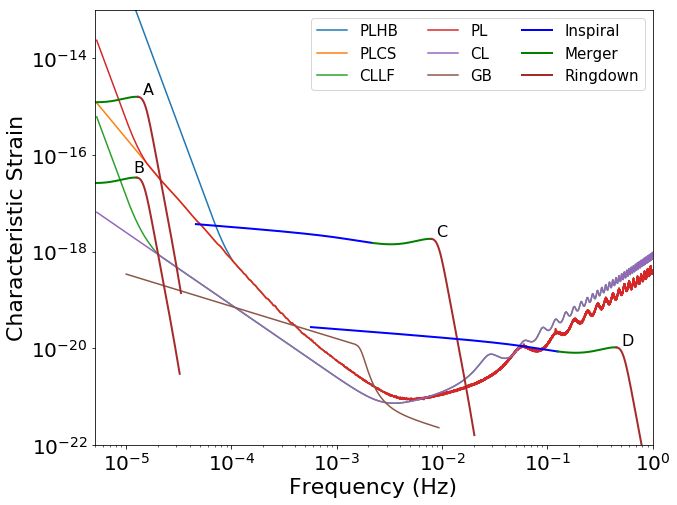

In [5]:
fig2 = plt.figure()
fig2.set_size_inches(10,8)
for name in ['PLHB', 'PLCS', 'CLLF', 'PL', 'CL', 'HB_wd_noise']:
    f, hn = read_noise_curve(name, noise_type_in='ASD', noise_type_out='char_strain')
    if name == 'HB_wd_noise':
        name = 'GB'
    plt.loglog(f, hn, label = name)
    
# initialize the waveform generator
phenomdwave = PhenomDWaveforms(dist_type='redshift', num_points=4096)
    
q = 1.0
s = 0.0
start_time = 1.0
end_time = 0.0
for M, z, letter in [[7e8, .75, 'A'],[6e7,20.0, 'B'], [1e6, 1.0, 'C'], [1e4, 2.5, 'D']]:
    m1 = M/(1+q)
    m2 = M*q/(1+q)
    wave = phenomdwave(m1, m2, s, s, z, start_time, end_time)

    f = wave.freqs
    hc = wave.hc*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018

    snr_out = snr(m1, m2, s, s, z, start_time, end_time, 
              add_wd_noise='yes', 
              prefactor=np.sqrt(2*16/5) , 
              sensitivity_curves=['PL', 'CL', 'PLHB', 'PLCS', 'CLLF'])
    
    print(letter, 'SNR:')
    trans = ''
    for key in snr_out:
        trans += key.split('_')[0] + ': '
        trans += '%i'%snr_out[key]
        trans += '  '
    print(trans)
    
    ins = np.where(f<wave.fmrg)[0]
    mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
    rd = np.where(f>wave.fpeak)[0]

    plt.loglog(f[ins], hc[ins], color='blue', lw=2)
    plt.loglog(f[mrg], hc[mrg], color='green', lw=2)
    plt.loglog(f[rd], hc[rd], color='brown', lw=2)
    
    if letter == 'B':
        plt.text(f[rd][0]*0.93, hc[rd][0]*1.28, letter, fontdict={'fontsize':16})
    else:
        plt.text(f[rd][0]*1.12, hc[rd][0]*1.12, letter, fontdict={'fontsize':16})


plt.plot(1,1, color='blue', lw=2, label='Inspiral')
plt.plot(1,1, color='green', lw=2, label='Merger')
plt.plot(1,1, color='brown', lw=2, label='Ringdown')

plt.xlim(5e-6,1e0)
plt.ylim(1e-22, 1e-13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'Characteristic Strain', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=22)
plt.legend(loc='upper right', ncol = 3, prop={'size':15})
#fig2.savefig('Phase_tracks2.png', dpi=250)

## Figure 4: Main Comparison with Galactic Background Noise

In [25]:
main_comp_generate = GenInput(print_input=True)

# main inputs
main_comp_generate.set_signal_type(['all', 'ins', 'mrg', 'rd'])
main_comp_generate.set_generation_type(num_processors=-1, verbose=50)
main_comp_generate.set_wd_noise('Both')

# output_info
main_comp_generate.set_output_file('paper_data/q5_s8T.hdf5')
main_comp_generate.set_x_col_name('M_s')
main_comp_generate.set_y_col_name('z')
main_comp_generate.add_note("The White Dwarf Noise is the Hils-Bender Approximation.")

# input sensitivity info
for nc in ['PL', 'CL', 'CLLF', 'PLHB', 'PLCS']:
    main_comp_generate.add_noise_curve(nc, noise_type='ASD')
                                    
main_comp_generate.add_noise_curve('HB_wd_noise', noise_type='ASD', is_wd_background=True)

# generation info
main_comp_generate.set_x_grid_info(1e2, 1e10, 100, 'log', 'total_mass', 'SolarMasses')
main_comp_generate.set_y_grid_info(1e-2, 1e2, 100, 'log', 'redshift', 'None')

main_comp_generate.add_fixed_parameter(1, 0.2, 'mass_ratio', 'None')
main_comp_generate.add_fixed_parameter(2, 0.8, 'spin_1', 'None')
main_comp_generate.add_fixed_parameter(3, 0.8, 'spin_2', 'None')
main_comp_generate.add_fixed_parameter(4, 1.0, 'start_time', 'Years')
main_comp_generate.add_fixed_parameter(5, 0.0, 'end_time', 'Years')

# add LISA averaging factor
main_comp_generate.set_snr_prefactor(np.sqrt(2.*16./5.))
                                    
# change number of waveform points for efficiency
main_comp_generate.set_num_waveform_points(4096)

generate_contour_data(main_comp_generate)

{'parallel_input': {'verbose': 50, 'num_processors': -1, 'num_splits': 1000}, 'sensitivity_input': {'sensitivity_curves': ['PL', 'CL', 'CLLF', 'PLHB', 'PLCS'], 'wd_noise_type_in': 'ASD', 'noise_type_in': ['ASD', 'ASD', 'ASD', 'ASD', 'ASD'], 'wd_noise': 'HB_wd_noise', 'add_wd_noise': 'Both'}, 'general': {}, 'output_info': {'y_col_name': 'z', 'output_file_name': 'paper_data/q5_s8T.hdf5', 'added_note': 'The White Dwarf Noise is the Hils-Bender Approximation.', 'x_col_name': 'M_s'}, 'generate_info': {'yval_name': 'redshift', 'xval_name': 'total_mass', 'y_high': 100.0, 'fixed_parameter_4': 1.0, 'fixed_parameter_2': 0.8, 'yscale': 'log', 'x_high': 10000000000.0, 'par_2_unit': 'None', 'num_y': 100, 'par_1_name': 'mass_ratio', 'num_x': 100, 'y_low': 0.01, 'yval_unit': 'None', 'fixed_parameter_5': 0.0, 'par_1_unit': 'None', 'x_low': 100.0, 'par_3_name': 'spin_2', 'par_2_name': 'spin_1', 'par_4_name': 'start_time', 'fixed_parameter_1': 0.2, 'fixed_parameter_3': 0.8, 'xscale': 'log', 'par_5_unit'

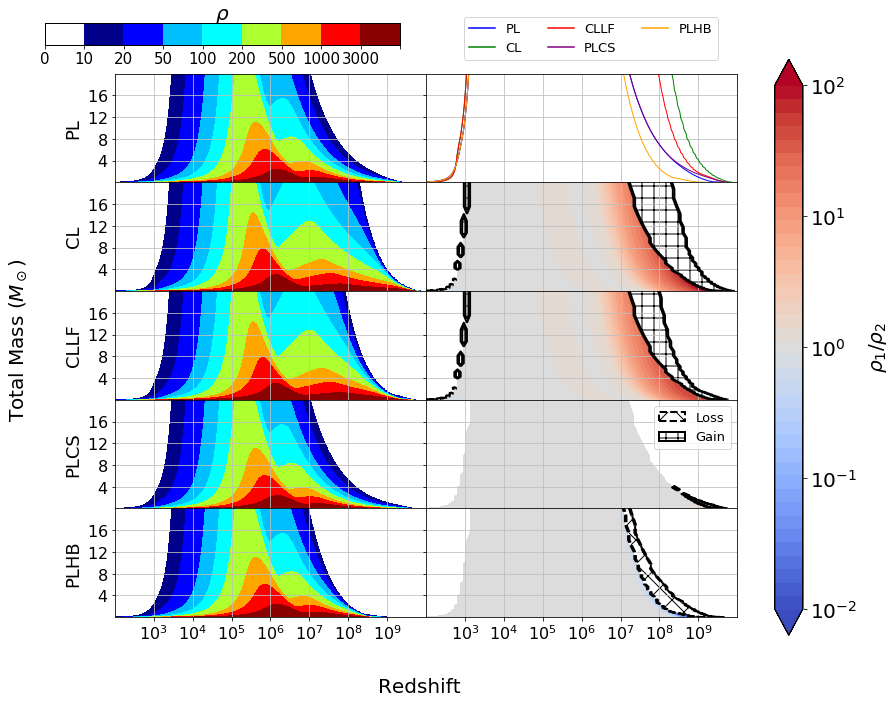

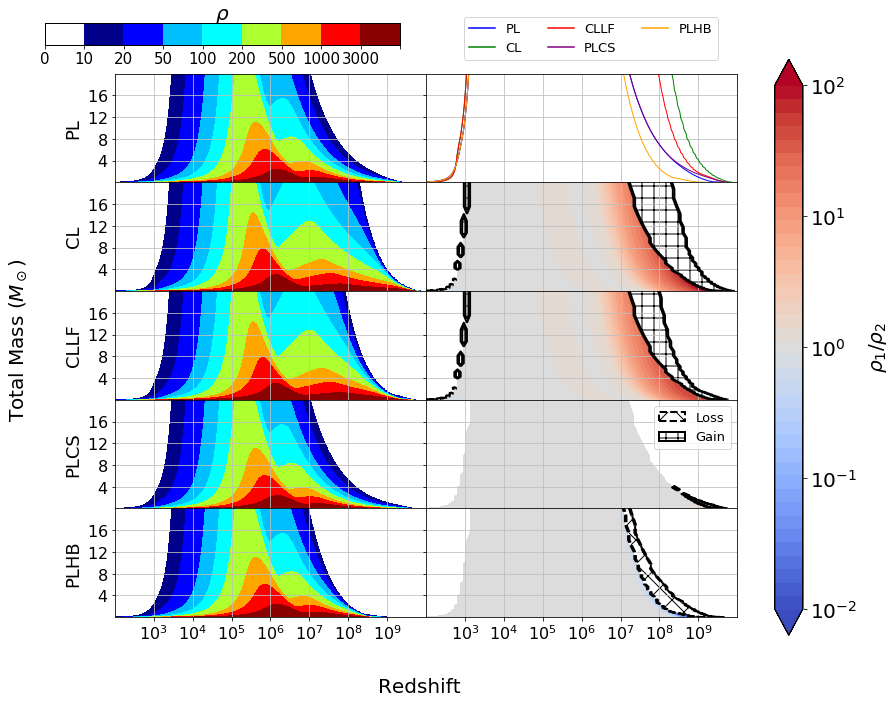

In [11]:
main_comp_plot_wd = PlotInput(nrows=5, ncols=2, print_input=False)

# set general info
main_comp_plot_wd.set_working_directory("./paper_data/")
main_comp_plot_wd.set_all_file_column_labels(xlabel='M_s', ylabel='z')
main_comp_plot_wd.set_fig_size(13.0, 10.0)
main_comp_plot_wd.set_all_xlims([2.0, 10.0], 1.0, 'log', fontsize=16)
main_comp_plot_wd.set_all_ylims([0.0, 20.0], 4.0, 'lin', fontsize=16)
main_comp_plot_wd.set_fig_x_label(xlabel=r"Total Mass ($M_\odot$)")
main_comp_plot_wd.set_fig_y_label(ylabel="Redshift")
main_comp_plot_wd.set_all_file_name("q5_s8T.hdf5")
main_comp_plot_wd.set_snr_cut(5.0)
main_comp_plot_wd.set_spacing('tight')

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
main_comp_plot_wd.set_colorbar('Waterfall', pos=3, ticks_fontsize=15)
main_comp_plot_wd.set_colorbar('Ratio', pos=5, ticks_fontsize=20)


# set plot_info
sensitivity_curves = ['PL', 'CL', 'CLLF', 'PLCS', 'PLHB']
control = 'PL'

# add left column waterfall plots
for i, label in enumerate(['PL', 'CL', 'CLLF', 'PLCS', 'PLHB']):
    main_comp_plot_wd.ax[2*i].set_plot_type('Waterfall')
    main_comp_plot_wd.ax[2*i].add_dataset(label=label + "_wd_all")
    main_comp_plot_wd.ax[2*i].set_ylabel(label)

# add horizon plot in top right
main_comp_plot_wd.ax[1].set_plot_type('Horizon')
for i in np.arange(len(sensitivity_curves)):
    main_comp_plot_wd.ax[1].add_dataset(index=2*i)
    
# add legend for horizon plot
main_comp_plot_wd.ax[1].add_legend(["PL", "CL", "CLLF", "PLCS", "PLHB"],
                                    loc='upper left',
                                    bbox_to_anchor=[0.1, 1.58],
                                    size=13,
                                    ncol=3)

# add loss/gain legend to plot that is clear to show it
main_comp_plot_wd.ax[7].add_legend(size=13)

# add ratio plots in right column
for i in np.arange(1, len(sensitivity_curves)):
    main_comp_plot_wd.ax[2*i+1].set_plot_type('Ratio')
    main_comp_plot_wd.ax[2*i+1].add_dataset(index=2*i)
    main_comp_plot_wd.ax[2*i+1].add_dataset(index=0, control=True)

plot_main(main_comp_plot_wd)

## Figure 5: Stage of Coalescence Comparison

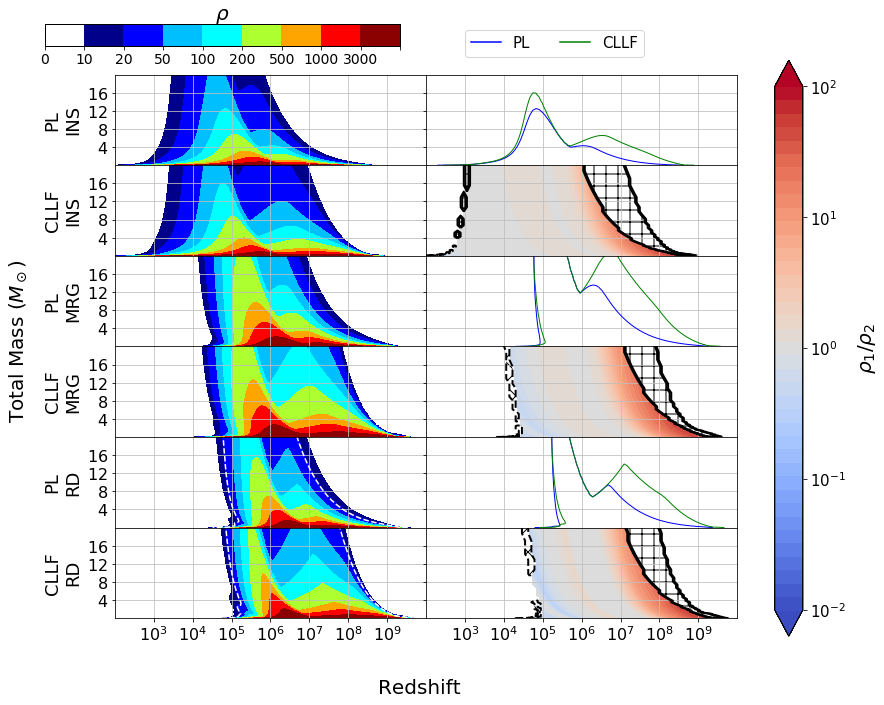

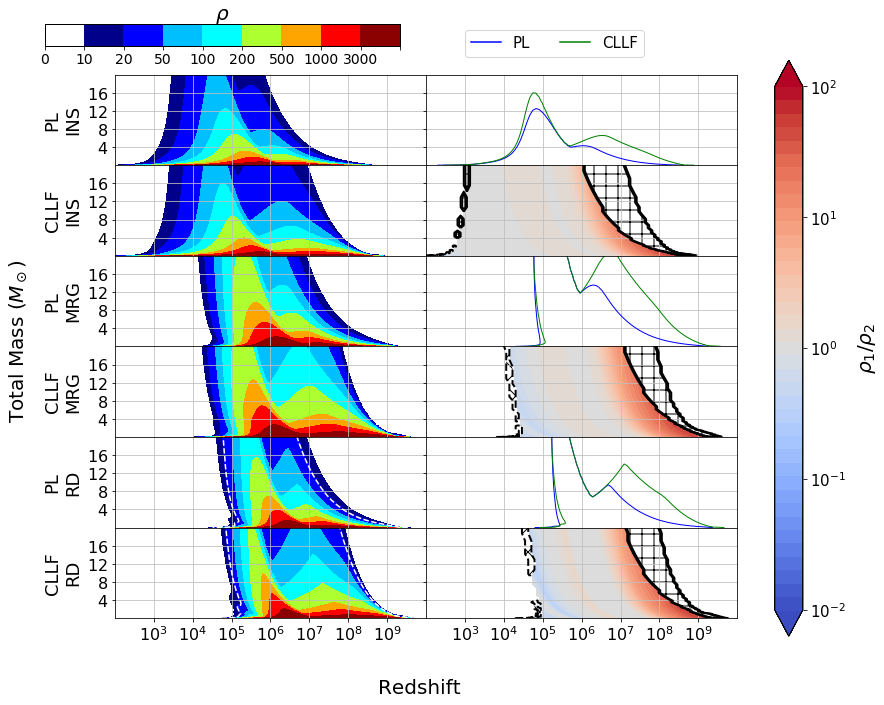

In [8]:
stage_plot_wd = PlotInput(nrows=6, ncols=2, print_input=False)

# set general info
stage_plot_wd.set_working_directory("./paper_data/")
stage_plot_wd.set_all_file_column_labels(xlabel='M_s', ylabel='z')
stage_plot_wd.set_fig_size(13.0, 10.0)
stage_plot_wd.set_all_xlims([2.0, 10.0], 1.0, 'log', fontsize=16)
stage_plot_wd.set_all_ylims([0.0, 20.0], 4.0, 'lin', fontsize=16)
stage_plot_wd.set_fig_x_label(xlabel=r"Total Mass ($M_\odot$)")
stage_plot_wd.set_fig_y_label(ylabel="Redshift")
stage_plot_wd.set_all_file_name("q5_s8T.hdf5")
stage_plot_wd.set_snr_cut(5.0)
stage_plot_wd.set_spacing('tight')

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
stage_plot_wd.set_colorbar('Waterfall', pos=3, ticks_fontsize=14)
stage_plot_wd.set_colorbar('Ratio', pos=5)


# set plot_info
sensitivity_curves = ['PL', 'CL', 'CLLF', 'PLCS', 'PLHB']
control = 'PL'

# add left column waterfall plots
for i, stage in enumerate(['INS', 'MRG', 'RD']):
    for j, label in enumerate(['PL', 'CLLF']):
        stage_plot_wd.ax[4*i + 2*j].set_plot_type('Waterfall')
        stage_plot_wd.ax[4*i + 2*j].add_dataset(label=label + "_wd_" + stage.lower())
        stage_plot_wd.ax[4*i + 2*j].set_ylabel(label + "\n" + stage)
        
        # add spectroscopic contours
        if stage == 'RD':
            stage_plot_wd.ax[4*i + 2*j].set_snr_contour_value(21.221441)

# add horizon plots to right column
for i, stage in enumerate(['INS', 'MRG', 'RD']):
    stage_plot_wd.ax[4*i + 1].set_plot_type('Horizon')
    stage_plot_wd.ax[4*i + 1].set_snr_contour_value(100.0)
    
    for j, label in enumerate(['PL', 'CLLF']):
        stage_plot_wd.ax[4*i + 1].add_dataset(index=4*i + 2*j)
        
        
    
# add legend for horizon plot
stage_plot_wd.ax[1].add_legend(["PL", "CLLF"],
                                    loc='upper left',
                                    bbox_to_anchor=[0.1, 1.58],
                                    size=15,
                                    ncol=2)

# add ratio plots in right column
for i, stage in enumerate(['INS', 'MRG', 'RD']):
    stage_plot_wd.ax[4*i + 3].set_plot_type('Ratio')
    
    for j, label in enumerate(['PL', 'CLLF']):
        if label == 'PL':
            control = True
        else:
            control = False
            
        stage_plot_wd.ax[4*i + 3].add_dataset(index=4*i + 2*j, control=control)

plot_main(stage_plot_wd)

## Figure 6: Spin and Mass Ratio Comparison 

In [24]:
spin_mass_generate.general.__dict__

{}

{}

In [26]:
spin_mass_generate = copy.deepcopy(main_comp_generate)

spin_mass_generate.sensitivity_input.sensitivity_curves = ['PL', 'CLLF']
spin_mass_generate.snr_input.signal_type = ['all']
spin_mass_generate.sensitivity_input.add_wd_noise = 'True'

# when the original class was created, it turned a str of ASD
# into a list the same length as sensitivity curves
spin_mass_generate.sensitivity_input.noise_type_in = 'ASD'

for mr in [0.02, 0.002]:
    spin_mass_generate.generate_info.fixed_parameter_1 = mr

    for spin in [-0.99, 0.0, 0.99]:
        spin_mass_generate.generate_info.fixed_parameter_2 = spin
        spin_mass_generate.generate_info.fixed_parameter_3 = spin

        if spin != -0.99:
            spin_mass_generate.output_info.output_file_name = "paper_data/q%i_s%iT.hdf5"%(int(1/mr), int(100*spin))

        else:
            spin_mass_generate.output_info.output_file_name = "paper_data/q%i_sn%iT.hdf5"%(int(1/mr), int(-100*spin))

        generate_contour_data(spin_mass_generate)

{'parallel_input': {'verbose': 50, 'num_processors': -1, 'num_splits': 1000}, 'sensitivity_input': {'sensitivity_curves': ['PL', 'CLLF'], 'wd_noise_type_in': 'ASD', 'noise_type_in': 'ASD', 'wd_noise': 'HB_wd_noise', 'add_wd_noise': 'True'}, 'general': {}, 'output_info': {'y_col_name': 'z', 'output_file_name': 'paper_data/q50_sn99T.hdf5', 'added_note': 'The White Dwarf Noise is the Hils-Bender Approximation.', 'x_col_name': 'M_s'}, 'generate_info': {'yval_name': 'redshift', 'xval_name': 'total_mass', 'y_high': 100.0, 'fixed_parameter_4': 1.0, 'fixed_parameter_2': -0.99, 'yscale': 'log', 'x_high': 10000000000.0, 'par_2_unit': 'None', 'num_y': 100, 'par_1_name': 'mass_ratio', 'num_x': 100, 'y_low': 0.01, 'yval_unit': 'None', 'fixed_parameter_5': 0.0, 'par_1_unit': 'None', 'x_low': 100.0, 'par_3_name': 'spin_2', 'par_2_name': 'spin_1', 'par_4_name': 'start_time', 'fixed_parameter_1': 0.02, 'fixed_parameter_3': -0.99, 'xscale': 'log', 'par_5_unit': 'Years', 'par_3_unit': 'None', 'par_4_unit

outputing file: ./paper_data/q50_s99T.hdf5
9.799935102462769
{'parallel_input': {'verbose': 50, 'num_processors': -1, 'num_splits': 1000}, 'sensitivity_input': {'sensitivity_curves': ['PL', 'CLLF'], 'wd_noise_type_in': 'ASD', 'noise_type_in': 'ASD', 'wd_noise': 'HB_wd_noise', 'add_wd_noise': 'True'}, 'general': {}, 'output_info': {'y_col_name': 'z', 'output_file_name': 'paper_data/q500_sn99T.hdf5', 'added_note': 'The White Dwarf Noise is the Hils-Bender Approximation.', 'x_col_name': 'M_s'}, 'generate_info': {'yval_name': 'redshift', 'xval_name': 'total_mass', 'y_high': 100.0, 'fixed_parameter_4': 1.0, 'fixed_parameter_2': -0.99, 'yscale': 'log', 'x_high': 10000000000.0, 'par_2_unit': 'None', 'num_y': 100, 'par_1_name': 'mass_ratio', 'num_x': 100, 'y_low': 0.01, 'yval_unit': 'None', 'fixed_parameter_5': 0.0, 'par_1_unit': 'None', 'x_low': 100.0, 'par_3_name': 'spin_2', 'par_2_name': 'spin_1', 'par_4_name': 'start_time', 'fixed_parameter_1': 0.002, 'fixed_parameter_3': -0.99, 'xscale': 

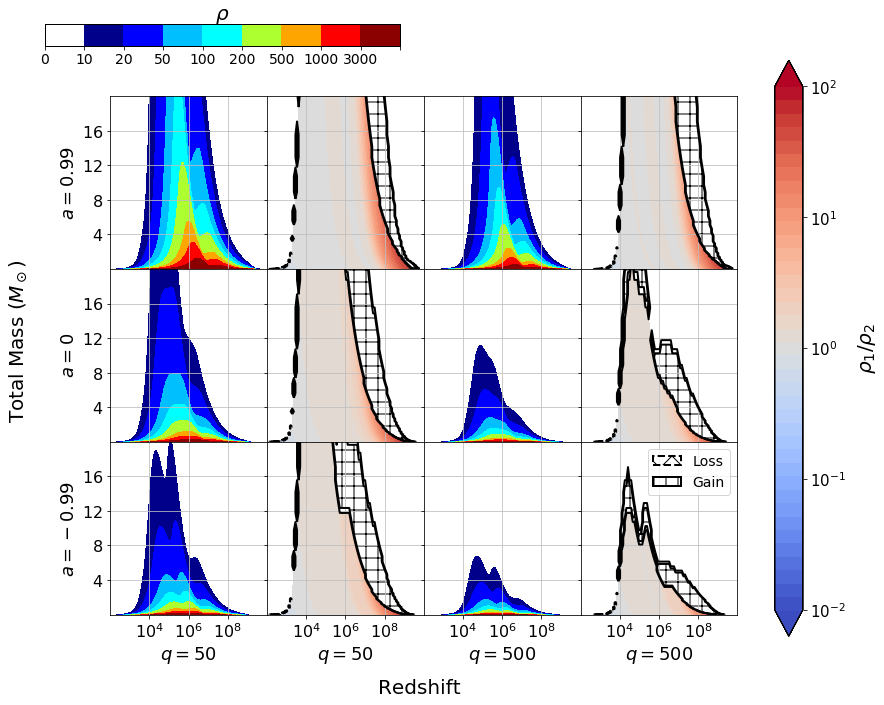

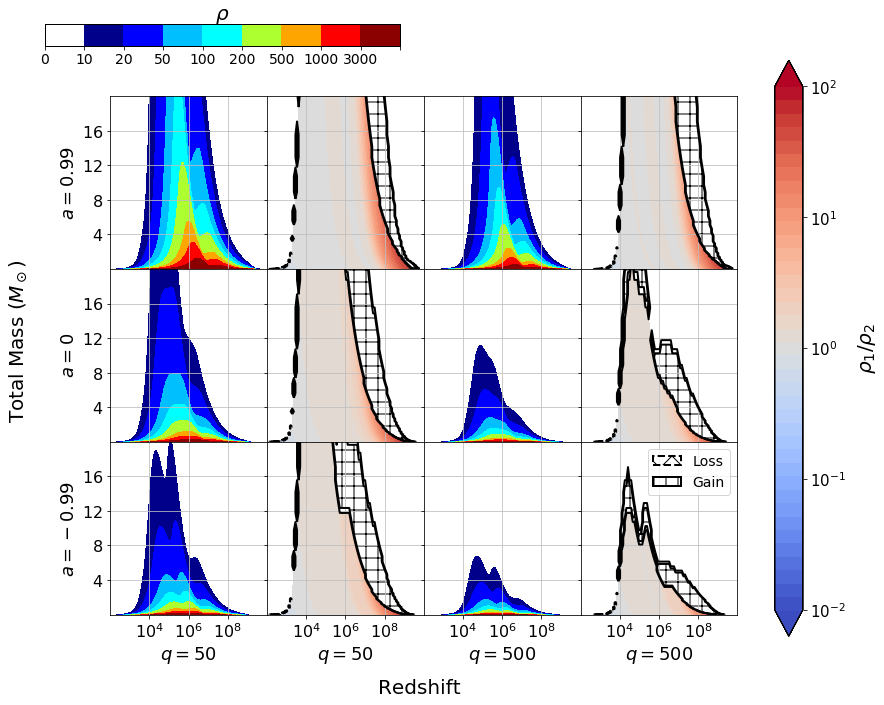

In [27]:
spin_mass_plot_wd = PlotInput(nrows=3, ncols=4, print_input=False)

# set general info
spin_mass_plot_wd.set_working_directory("./paper_data")
spin_mass_plot_wd.set_all_file_column_labels(xlabel='M_s', ylabel='z')
spin_mass_plot_wd.set_fig_size(13.0, 10.0)
spin_mass_plot_wd.set_all_xlims([2.0, 10.0], 2.0, 'log', fontsize=16)
spin_mass_plot_wd.set_all_ylims([0.0, 20.0], 4.0, 'lin', fontsize=16)
spin_mass_plot_wd.set_fig_x_label(xlabel=r"Total Mass ($M_\odot$)")
spin_mass_plot_wd.set_fig_y_label(ylabel="Redshift")
spin_mass_plot_wd.set_snr_cut(5.0)
spin_mass_plot_wd.set_spacing('tight')
spin_mass_plot_wd.subplots_adjust(bottom=0.13)

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
spin_mass_plot_wd.set_colorbar('Waterfall', pos=3, ticks_fontsize=14)
spin_mass_plot_wd.set_colorbar('Ratio', pos=5)


# set plot_info
sensitivity_curves = ['PL', 'CLLF']
control = 'PL'

for i, spin in enumerate([0.99, 0.0, -0.99]):
    for j, mr in enumerate([0.02, 0.002]):
        if spin != -0.99:
            name = "q%i_s%iT.hdf5"%(int(1/mr), int(100*spin))
        else:
            name = "q%i_sn%iT.hdf5"%(int(1/mr), int(-100*spin))
            
        # add waterfall
        spin_mass_plot_wd.ax[4*i + 2*j].set_plot_type('Waterfall')
        spin_mass_plot_wd.ax[4*i + 2*j].add_dataset(name=name, label="PL_wd_all")
       
        # add corresponding ratio plots
        spin_mass_plot_wd.ax[4*i + 2*j + 1].set_plot_type('Ratio')
        spin_mass_plot_wd.ax[4*i + 2*j + 1].add_dataset(name=name, label="PL_wd_all", control=True)
        spin_mass_plot_wd.ax[4*i + 2*j + 1].add_dataset(name=name, label="CLLF_wd_all", control=False)
        
        # add labels
        if j == 0:
            spin_mass_plot_wd.ax[4*i + 2*j].set_ylabel(r"$a=%.2g$"%spin, fontsize=18)
        
        if i == 2:
            spin_mass_plot_wd.ax[4*i + 2*j].set_xlabel(r"$q=%i$"%(1/mr), fontsize=18)
            spin_mass_plot_wd.ax[4*i + 2*j + 1].set_xlabel(r"$q=%i$"%(1/mr), fontsize=18)
            
# add legend for loss/gain
spin_mass_plot_wd.ax[-1].add_legend(size=14)

plot_main(spin_mass_plot_wd)

## Main Comparison (No White Dwarf Noise; not in paper)

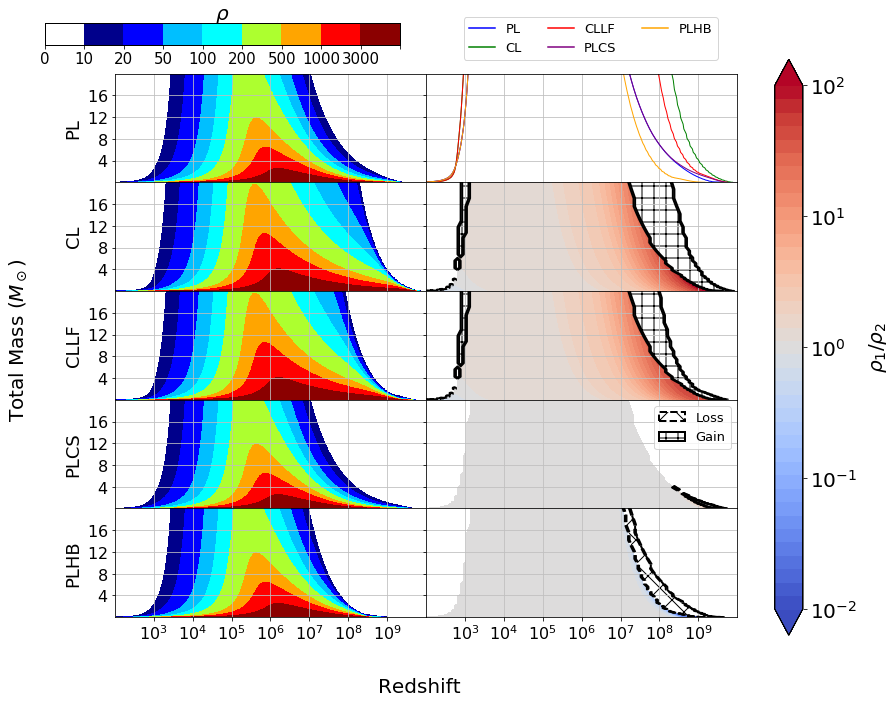

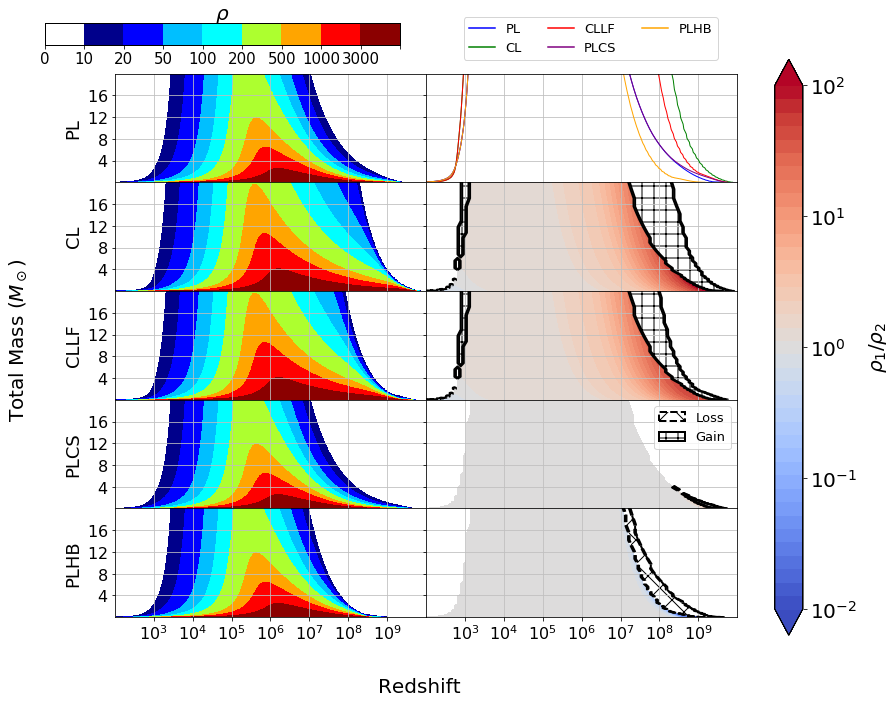

In [12]:
main_comp_plot = copy.deepcopy(main_comp_plot_wd)

# change labels to remove wd noise
for i, label in enumerate(['PL', 'CL', 'CLLF', 'PLCS', 'PLHB']):
    main_comp_plot.ax[2*i].file[0].label = label + "_all"
    
plot_main(main_comp_plot)

## Mass Ratio Comparison (not in paper)

In [28]:
mass_ratio_generate = copy.deepcopy(main_comp_generate)
mass_ratio_generate.sensitivity_input.sensitivity_curves =  ["PL", "CLLF"]
mass_ratio_generate.set_wd_noise(True)
mass_ratio_generate.sensitivity_input.noise_type_in = 'ASD'

for mr in [0.02, 0.002]:
    mass_ratio_generate.generate_info.fixed_parameter_1 = mr
    mass_ratio_generate.output_info.output_file_name = "example_data/q%i_s8.hdf5"%(int(1/mr))
    generate_contour_data(mass_ratio_generate)

{'parallel_input': {'verbose': 50, 'num_processors': -1, 'num_splits': 1000}, 'sensitivity_input': {'sensitivity_curves': ['PL', 'CLLF'], 'wd_noise_type_in': 'ASD', 'noise_type_in': 'ASD', 'wd_noise': 'HB_wd_noise', 'add_wd_noise': 'True'}, 'general': {}, 'output_info': {'y_col_name': 'z', 'output_file_name': 'example_data/q50_s8.hdf5', 'added_note': 'The White Dwarf Noise is the Hils-Bender Approximation.', 'x_col_name': 'M_s'}, 'generate_info': {'yval_name': 'redshift', 'xval_name': 'total_mass', 'y_high': 100.0, 'fixed_parameter_4': 1.0, 'fixed_parameter_2': 0.8, 'yscale': 'log', 'x_high': 10000000000.0, 'par_2_unit': 'None', 'num_y': 100, 'par_1_name': 'mass_ratio', 'num_x': 100, 'y_low': 0.01, 'yval_unit': 'None', 'fixed_parameter_5': 0.0, 'par_1_unit': 'None', 'x_low': 100.0, 'par_3_name': 'spin_2', 'par_2_name': 'spin_1', 'par_4_name': 'start_time', 'fixed_parameter_1': 0.02, 'fixed_parameter_3': 0.8, 'xscale': 'log', 'par_5_unit': 'Years', 'par_3_unit': 'None', 'par_4_unit': 'Y

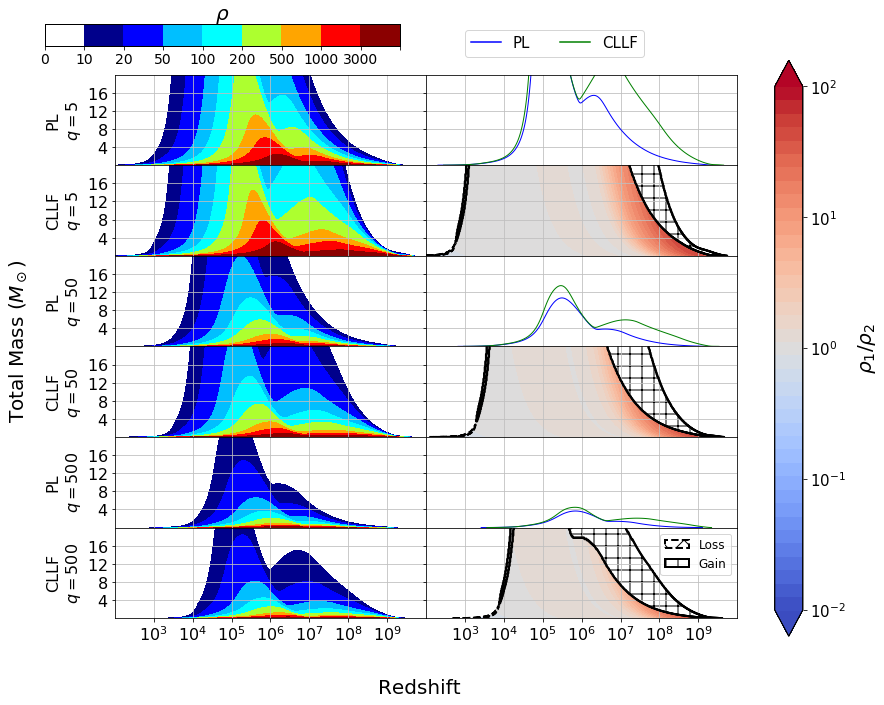

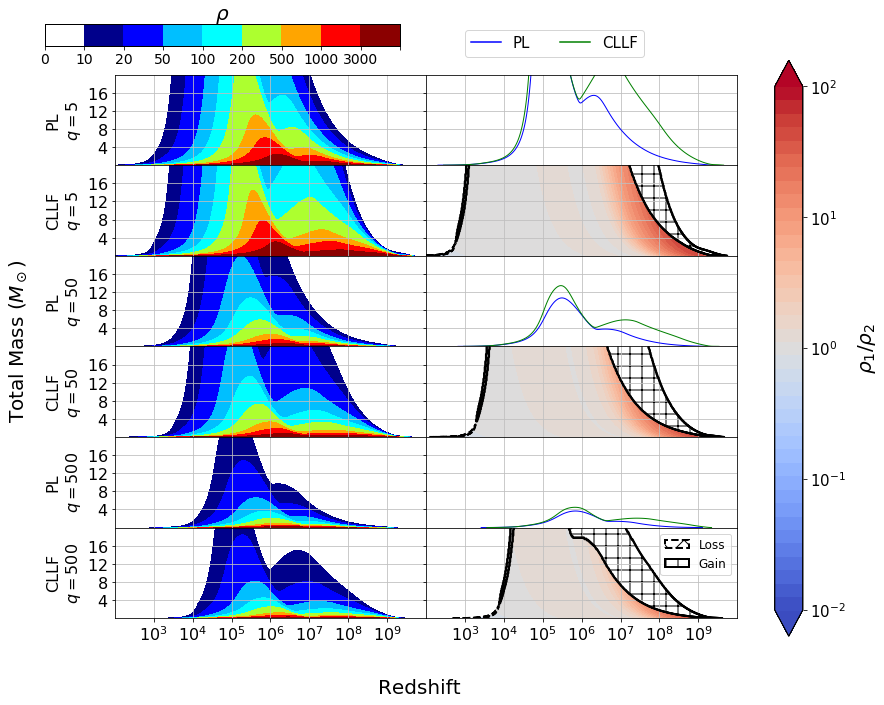

In [29]:
mass_ratio_plot = PlotInput(nrows=6, ncols=2, print_input=False)

# set general info
mass_ratio_plot.set_working_directory("./paper_data/")
mass_ratio_plot.set_all_file_column_labels(xlabel='M_s', ylabel='z')
mass_ratio_plot.set_fig_size(13.0, 10.0)
mass_ratio_plot.set_all_xlims([2.0, 10.0], 1.0, 'log', fontsize=16)
mass_ratio_plot.set_all_ylims([0.0, 20.0], 4.0, 'lin', fontsize=16)
mass_ratio_plot.set_fig_x_label(xlabel=r"Total Mass ($M_\odot$)")
mass_ratio_plot.set_fig_y_label(ylabel="Redshift")
mass_ratio_plot.set_snr_cut(5.0)
mass_ratio_plot.set_spacing('tight')

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
mass_ratio_plot.set_colorbar('Waterfall', pos=3, ticks_fontsize=14)
mass_ratio_plot.set_colorbar('Ratio', pos=5)


# set plot_info
sensitivity_curves = ['PL', 'CL', 'CLLF', 'PLCS', 'PLHB']
control = 'PL'

# add left column waterfall plots
for i, mr in enumerate([5, 50, 500]):
    for j, label in enumerate(['PL', 'CLLF']):
        mass_ratio_plot.ax[4*i + 2*j].set_plot_type('Waterfall')
        mass_ratio_plot.ax[4*i + 2*j].add_dataset(name='q%i_s8.hdf5'%mr, label=label + "_wd_all")
        mass_ratio_plot.ax[4*i + 2*j].set_ylabel(label + "\n" + r'$q=%i$'%mr, fontsize=16)
        
# add horizon plots to right column
for i, mr in enumerate([5, 50, 500]):
    mass_ratio_plot.ax[4*i + 1].set_plot_type('Horizon')
    mass_ratio_plot.ax[4*i + 1].set_snr_contour_value(100.0)
    
    for j, label in enumerate(['PL', 'CLLF']):
        mass_ratio_plot.ax[4*i + 1].add_dataset(index=4*i + 2*j)
        
        
    
# add legend for horizon plot
mass_ratio_plot.ax[1].add_legend(["PL", "CLLF"],
                                 loc='upper left',
                                 bbox_to_anchor=[0.1, 1.58],
                                 size=15,
                                 ncol=2)

mass_ratio_plot.ax[-1].add_legend(size=12)

# add ratio plots in right column
for i, mr in enumerate([5, 50, 500]):
    mass_ratio_plot.ax[4*i + 3].set_plot_type('Ratio')
    
    for j, label in enumerate(['PL', 'CLLF']):
        if label == 'PL':
            control = True
        else:
            control = False
            
        mass_ratio_plot.ax[4*i + 3].add_dataset(index=4*i + 2*j, control=control)

plot_main(mass_ratio_plot)

## Spin Comparison (not in paper)

In [30]:
spin_generate = copy.deepcopy(main_comp_generate)
spin_generate.sensitivity_input.sensitivity_curves =  ["PL", "CLLF"]
spin_generate.set_wd_noise(True)
spin_generate.sensitivity_input.noise_type_in = 'ASD'

# set mass ratio
spin_generate.generate_info.fixed_parameter_1 = 0.002

for spin in [0.99, 0.0, -0.99]:
    spin_generate.generate_info.fixed_parameter_2 = spin
    spin_generate.generate_info.fixed_parameter_3 = spin
    
    if spin != -0.99:
        name = "example_data/q500_s%i.hdf5"%(int(100*spin))
    else:
        name = "example_data/q500_sn%i.hdf5"%(int(-100*spin))
    spin_generate.output_info.output_file_name = name
    
    generate_contour_data(spin_generate)

{'parallel_input': {'verbose': 50, 'num_processors': -1, 'num_splits': 1000}, 'sensitivity_input': {'sensitivity_curves': ['PL', 'CLLF'], 'wd_noise_type_in': 'ASD', 'noise_type_in': 'ASD', 'wd_noise': 'HB_wd_noise', 'add_wd_noise': 'True'}, 'general': {}, 'output_info': {'y_col_name': 'z', 'output_file_name': 'example_data/q500_s99.hdf5', 'added_note': 'The White Dwarf Noise is the Hils-Bender Approximation.', 'x_col_name': 'M_s'}, 'generate_info': {'yval_name': 'redshift', 'xval_name': 'total_mass', 'y_high': 100.0, 'fixed_parameter_4': 1.0, 'fixed_parameter_2': 0.99, 'yscale': 'log', 'x_high': 10000000000.0, 'par_2_unit': 'None', 'num_y': 100, 'par_1_name': 'mass_ratio', 'num_x': 100, 'y_low': 0.01, 'yval_unit': 'None', 'fixed_parameter_5': 0.0, 'par_1_unit': 'None', 'x_low': 100.0, 'par_3_name': 'spin_2', 'par_2_name': 'spin_1', 'par_4_name': 'start_time', 'fixed_parameter_1': 0.002, 'fixed_parameter_3': 0.99, 'xscale': 'log', 'par_5_unit': 'Years', 'par_3_unit': 'None', 'par_4_unit

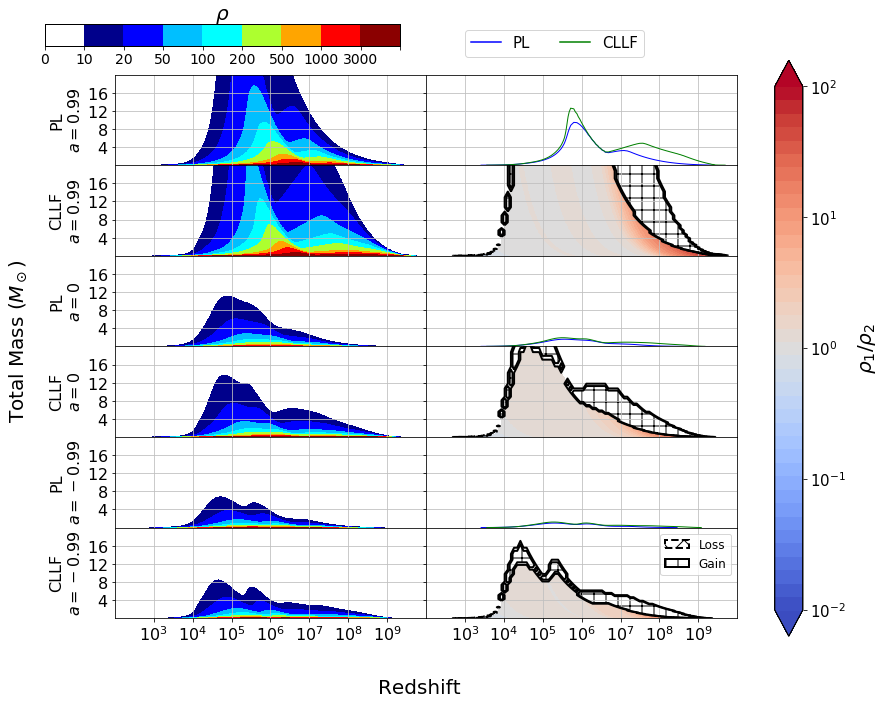

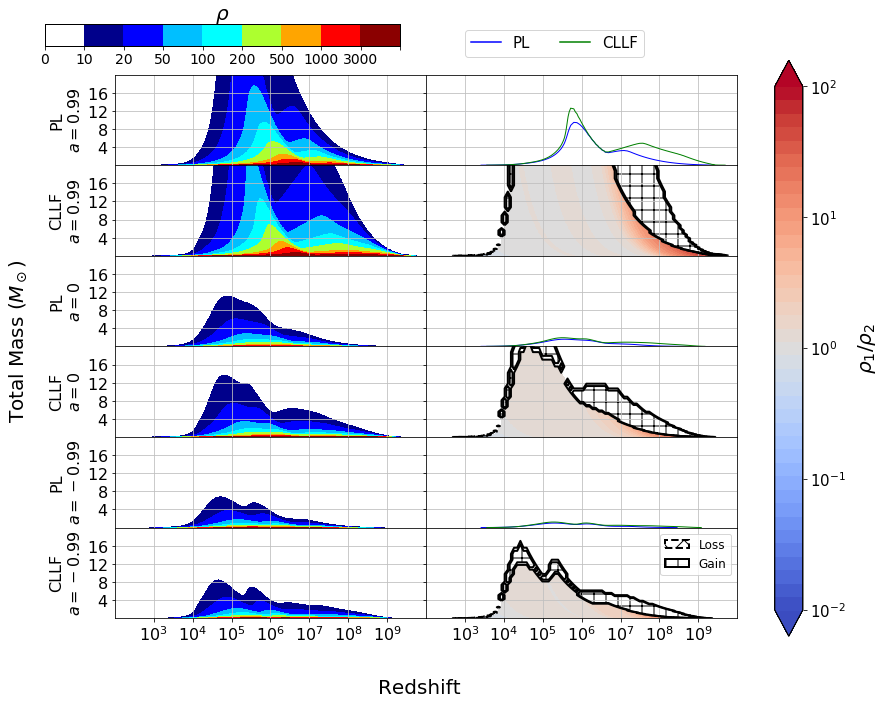

In [31]:
spin_plot = PlotInput(nrows=6, ncols=2, print_input=False)

# set general info
spin_plot.set_working_directory("./example_data")
spin_plot.set_all_file_column_labels(xlabel='M_s', ylabel='z')
spin_plot.set_fig_size(13.0, 10.0)
spin_plot.set_all_xlims([2.0, 10.0], 1.0, 'log', fontsize=16)
spin_plot.set_all_ylims([0.0, 20.0], 4.0, 'lin', fontsize=16)
spin_plot.set_fig_x_label(xlabel=r"Total Mass ($M_\odot$)")
spin_plot.set_fig_y_label(ylabel="Redshift")
spin_plot.set_snr_cut(5.0)
spin_plot.set_spacing('tight')

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
spin_plot.set_colorbar('Waterfall', pos=3, ticks_fontsize=14)
spin_plot.set_colorbar('Ratio', pos=5)


# add left column waterfall plots
for i, spin in enumerate([0.99, 0.0, -0.99]):
    for j, label in enumerate(['PL', 'CLLF']):
        spin_plot.ax[4*i + 2*j].set_plot_type('Waterfall')
        if spin != -0.99:
            name = "q500_s%i.hdf5"%(int(100*spin))
        else:
            name = "q500_sn%i.hdf5"%(int(-100*spin))
        spin_plot.ax[4*i + 2*j].add_dataset(name=name, label=label + "_wd_all")
        spin_plot.ax[4*i + 2*j].set_ylabel(label + "\n" + r'$a=%.2g$'%spin, fontsize=16)
        
# add horizon plots to right column
for i, spin in enumerate([0.99, 0.0, -0.99]):
    spin_plot.ax[4*i + 1].set_plot_type('Horizon')
    spin_plot.ax[4*i + 1].set_snr_contour_value(100.0)
    
    for j, label in enumerate(['PL', 'CLLF']):
        spin_plot.ax[4*i + 1].add_dataset(index=4*i + 2*j)
        
        
    
# add legend for horizon plot
spin_plot.ax[1].add_legend(["PL", "CLLF"],
                                 loc='upper left',
                                 bbox_to_anchor=[0.1, 1.58],
                                 size=15,
                                 ncol=2)

spin_plot.ax[-1].add_legend(size=12)

# add ratio plots in right column
for i, spin in enumerate([0.99, 0.0, -0.99]):
    spin_plot.ax[4*i + 3].set_plot_type('Ratio')
    
    for j, label in enumerate(['PL', 'CLLF']):
        if label == 'PL':
            control = True
        else:
            control = False
            
        spin_plot.ax[4*i + 3].add_dataset(index=4*i + 2*j, control=control)

plot_main(spin_plot)

## Gridding Sensitivity Curves (not in paper)

In [2]:
grid_sense_curves_generate = GenInput(print_input=False)

# main inputs
grid_sense_curves_generate.set_signal_type(['all'])
grid_sense_curves_generate.set_generation_type(num_processors=-1, verbose=50)
grid_sense_curves_generate.set_wd_noise(True)

# output_info
grid_sense_curves_generate.set_output_file('example_data/M8_z5T.hdf5')
grid_sense_curves_generate.set_x_col_name('q')
grid_sense_curves_generate.set_y_col_name('a')
grid_sense_curves_generate.add_note("The White Dwarf Noise is the Hils-Bender Approximation.")

# input sensitivity info
for nc in ['PL', 'CLLF', 'LPA']:
    grid_sense_curves_generate.add_noise_curve(nc, noise_type='ASD')
                                    
grid_sense_curves_generate.add_noise_curve('HB_wd_noise', noise_type='ASD', is_wd_background=True)

# generation info
grid_sense_curves_generate.set_x_grid_info(1e-4, 1e0, 100, 'log', 'mass_ratio', 'SolarMasses')
grid_sense_curves_generate.set_y_grid_info(-0.99, 0.99, 100, 'lin', 'spin', 'None')

grid_sense_curves_generate.add_fixed_parameter(1, 5.0, 'redshift', 'None')
grid_sense_curves_generate.add_fixed_parameter(2, 1e8, 'total_mass', 'None')
grid_sense_curves_generate.add_fixed_parameter(3, 1.0, 'start_time', 'Years')
grid_sense_curves_generate.add_fixed_parameter(4, 0.0, 'end_time', 'Years')

# add LISA averaging factor
grid_sense_curves_generate.set_snr_prefactor(np.sqrt(2.*16./5.))
                                    
# change number of waveform points for efficiency
grid_sense_curves_generate.set_num_waveform_points(4096)

generate_contour_data(grid_sense_curves_generate)

start pool with 4 processors: 10 total processes.

start pool with 4 processors: 10 total processes.

outputing file: ./example_data/M8_z5T.hdf5
6.678518056869507
outputing file: ./example_data/M8_z5T.hdf5
6.678518056869507


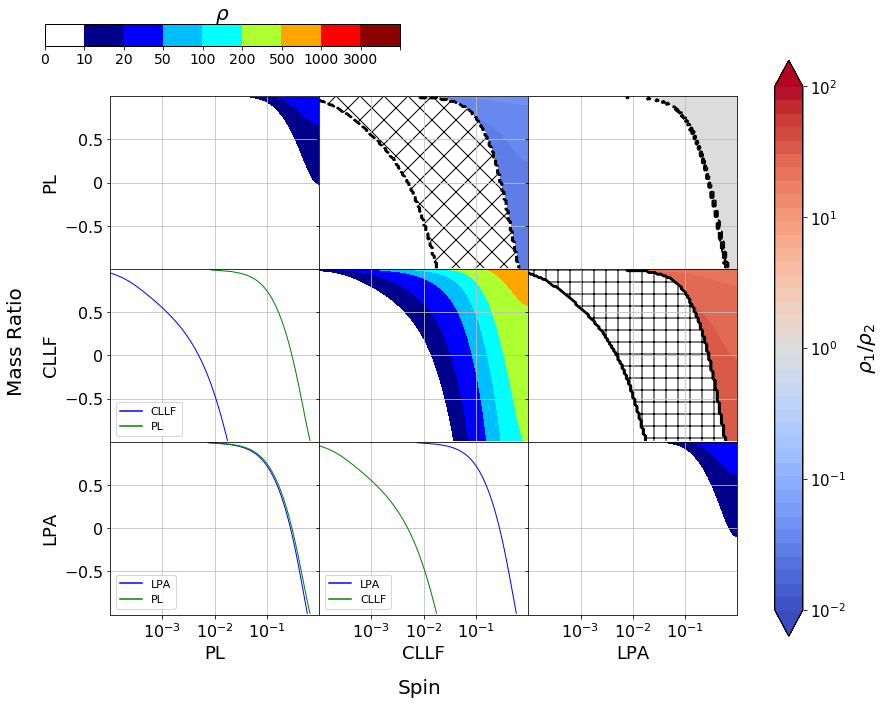

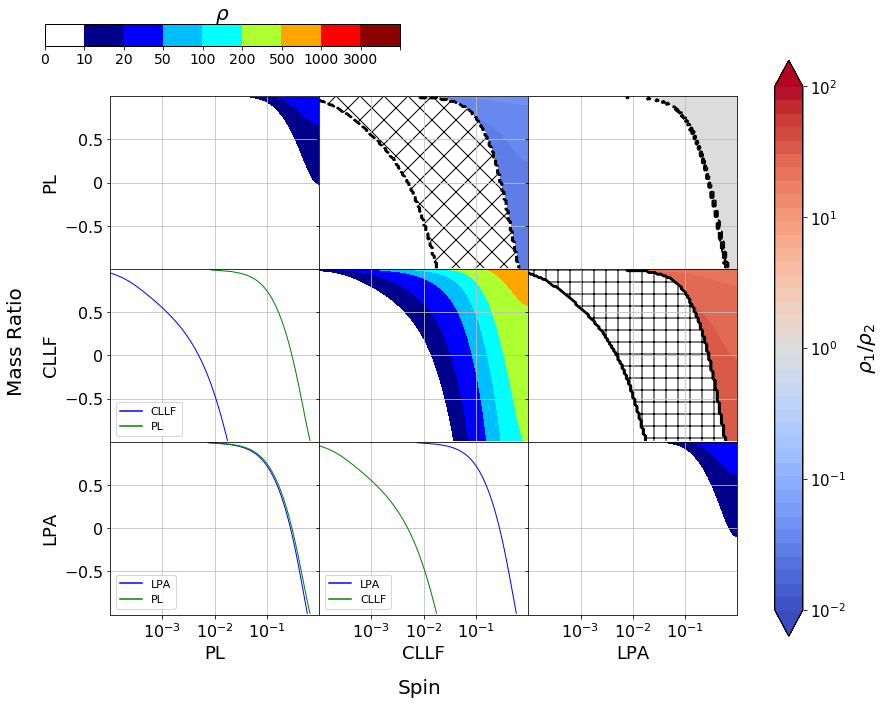

In [3]:
grid_sense_curves_plot = PlotInput(nrows=3, ncols=3, print_input=False)

# set general info
grid_sense_curves_plot.set_working_directory("./example_data/")
grid_sense_curves_plot.set_all_file_column_labels(xlabel='q', ylabel='a')
grid_sense_curves_plot.set_fig_size(13.0, 10.0)
grid_sense_curves_plot.set_all_xlims([-4.0, 0.0], 1.0, 'log', fontsize=16)
grid_sense_curves_plot.set_all_ylims([-1.0, 1.0], 0.5, 'lin', fontsize=16)
grid_sense_curves_plot.set_fig_x_label(xlabel=r"Mass Ratio")
grid_sense_curves_plot.set_fig_y_label(ylabel="Spin")
grid_sense_curves_plot.set_snr_cut(5.0)
grid_sense_curves_plot.set_spacing('tight')
grid_sense_curves_plot.set_all_file_name('M8_z5T.hdf5')

grid_sense_curves_plot.subplots_adjust(bottom=0.13)

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
grid_sense_curves_plot.set_colorbar('Waterfall', pos=3, ticks_fontsize=14)
grid_sense_curves_plot.set_colorbar('Ratio', pos=5)

# add diagonal waterfall plots
for i, (ind_plot, label) in enumerate([[0, 'PL'], [4, 'CLLF'], [8, 'LPA']]):
    grid_sense_curves_plot.ax[ind_plot].set_plot_type('Waterfall')
    grid_sense_curves_plot.ax[ind_plot].add_dataset(label=label + "_wd_all")
    
    #set labels
    grid_sense_curves_plot.ax[3*i].set_ylabel(label)
    grid_sense_curves_plot.ax[6+i].set_xlabel(label)
    
# add upper diagonal ratio plots
# [plot_index, index of comparison, index of control]
for ind_plot, ind_comp, ind_cont in [[1, 0, 4], [2, 0, 8], [5, 4, 8]]:
    grid_sense_curves_plot.ax[ind_plot].set_plot_type('Ratio')
    grid_sense_curves_plot.ax[ind_plot].add_dataset(index=ind_comp)
    grid_sense_curves_plot.ax[ind_plot].add_dataset(index=ind_cont, control=True)
    
# add lower diagonal horizon plots
# [plot_index, index of first curve, index of second curve]
legend_key = {'3': ['CLLF', 'PL'], '6': ['LPA', 'PL'], '7': ['LPA', 'CLLF']}
for ind_plot, ind_1, ind_2 in [[3, 4, 0], [6, 8, 0], [7, 8, 4]]:
    grid_sense_curves_plot.ax[ind_plot].set_plot_type('Horizon')
    grid_sense_curves_plot.ax[ind_plot].add_dataset(index=ind_1)
    grid_sense_curves_plot.ax[ind_plot].add_dataset(index=ind_2)
    grid_sense_curves_plot.ax[ind_plot].add_legend(legend_key[str(ind_plot)], size=11, loc='lower left')
    
    
plot_main(grid_sense_curves_plot)

## Gridding Binary Parameters (not in paper)

This will fix the sensitivity and compare binary parameters. The plot will show waterfall plots in the center column for $M=10^7_\odot$. The left and right columns ($M=10^6_\odot$ and $M=10^8_\odot$, repectively) show ratio plots comparing to the center column in each row.

In [4]:
grid_binary_pars_generate = copy.deepcopy(grid_sense_curves_generate)

for z in [0.5, 1.0, 5.0]:
    grid_binary_pars_generate.add_fixed_parameter(1, z, 'redshift', 'None')
    
    for M in [1e6, 1e7, 1e8]:
        grid_binary_pars_generate.add_fixed_parameter(2, M, 'total_mass', 'None')
        grid_binary_pars_generate.set_output_file("example_data/M%iz%02dT.hdf5"%(np.log10(M), 10*z))
        
        generate_contour_data(grid_binary_pars_generate)

start pool with 4 processors: 10 total processes.

start pool with 4 processors: 10 total processes.

outputing file: ./example_data/M6z05T.hdf5
8.191561937332153
outputing file: ./example_data/M6z05T.hdf5
8.191561937332153
start pool with 4 processors: 10 total processes.

start pool with 4 processors: 10 total processes.

outputing file: ./example_data/M7z05T.hdf5
7.817414999008179
outputing file: ./example_data/M7z05T.hdf5
7.817414999008179
start pool with 4 processors: 10 total processes.

start pool with 4 processors: 10 total processes.

outputing file: ./example_data/M8z05T.hdf5
10.921900033950806
outputing file: ./example_data/M8z05T.hdf5
10.921900033950806
start pool with 4 processors: 10 total processes.

start pool with 4 processors: 10 total processes.

outputing file: ./example_data/M6z10T.hdf5
9.078207969665527
outputing file: ./example_data/M6z10T.hdf5
9.078207969665527
start pool with 4 processors: 10 total processes.

start pool with 4 processors: 10 total processes.



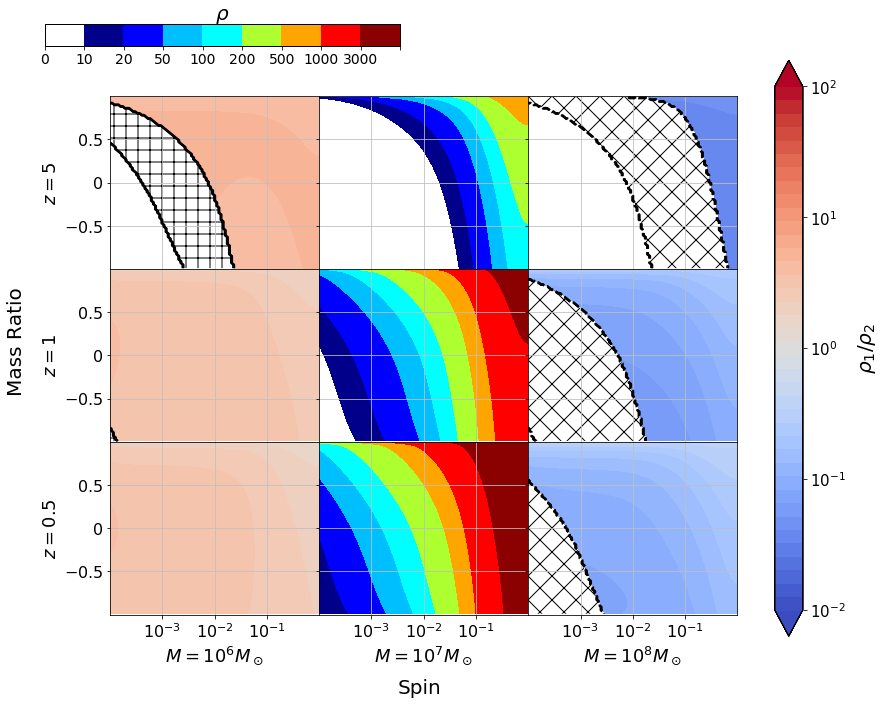

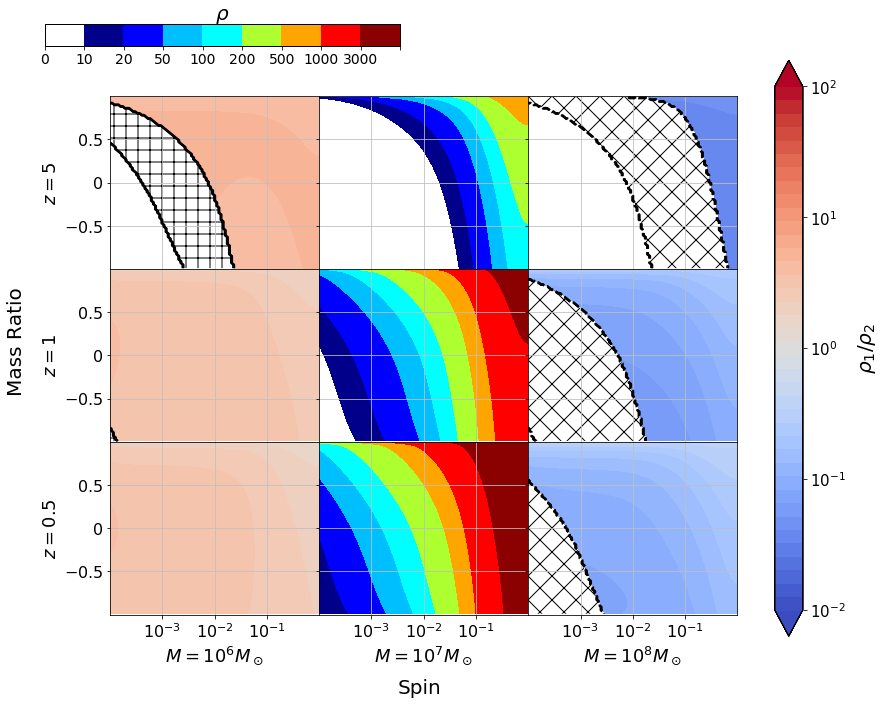

In [5]:
grid_binary_pars_plot = PlotInput(nrows=3, ncols=3, print_input=False)

# set general info
grid_binary_pars_plot.set_working_directory("./example_data/")
grid_binary_pars_plot.set_all_file_column_labels(xlabel='q', ylabel='a')
grid_binary_pars_plot.set_fig_size(13.0, 10.0)
grid_binary_pars_plot.set_all_xlims([-4.0, 0.0], 1.0, 'log', fontsize=16)
grid_binary_pars_plot.set_all_ylims([-1.0, 1.0], 0.5, 'lin', fontsize=16)
grid_binary_pars_plot.set_fig_x_label(xlabel=r"Mass Ratio")
grid_binary_pars_plot.set_fig_y_label(ylabel="Spin")
grid_binary_pars_plot.set_snr_cut(5.0)
grid_binary_pars_plot.set_spacing('tight')

grid_binary_pars_plot.subplots_adjust(bottom=0.13)

# set colorbar info
# pos=3 is top left, pos=5 is stretch to fit whole right side
grid_binary_pars_plot.set_colorbar('Waterfall', pos=3, ticks_fontsize=14)
grid_binary_pars_plot.set_colorbar('Ratio', pos=5)

# add center column waterfall plots for M = 1e7
M=1e7
for i, z in enumerate([5.0, 1.0, 0.5]):
    grid_binary_pars_plot.ax[3*i+1].set_plot_type('Waterfall')
    grid_binary_pars_plot.ax[3*i+1].add_dataset(name="M%iz%02dT.hdf5"%(np.log10(M), 10*z),
                                                label="PL_wd_all")

for M in [1e6, 1e8]:
    j = 0 if M == 1e6 else 2
    for i, z in enumerate([5.0, 1.0, 0.5]):
        grid_binary_pars_plot.ax[3*i+j].set_plot_type('Ratio')
        grid_binary_pars_plot.ax[3*i+j].add_dataset(name="M%iz%02dT.hdf5"%(np.log10(M), 10*z),
                                                label="PL_wd_all")
        grid_binary_pars_plot.ax[3*i+j].add_dataset(index=3*i+1, control=True)
        
# row labels
for i, z in enumerate([5.0, 1.0, 0.5]):
    grid_binary_pars_plot.ax[3*i].set_ylabel(r'$z=%.1g$'%z)
    
# column labels
for i, M in enumerate([1e6, 1e7, 1e8]):
    grid_binary_pars_plot.ax[6+i].set_xlabel(r'$M=10^{%.1g}M_\odot$'%np.log10(M))
    

plot_main(grid_binary_pars_plot)